In [1]:
import os
import glob
import cv2
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from skimage.feature import hog
from mpl_toolkits.mplot3d import Axes3D
import pydotplus 


# Features Extraction

In [86]:
def read_image(path):
    return(cv2.cvtColor(cv2.imread(path),cv2.COLOR_BGR2RGB))

def extract_hog(img, pix_per_cell=8, cell_per_block=2, orient=9, hog_idx=None):
    gray=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    hog_features = hog(gray, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=False, feature_vector=True)
    if hog_idx is None:
        return hog_features
    else:
        return hog_features[hog_idx]
    
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range, density=True)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range, density=True)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range, density=True)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to compute color histogram features  
# Pass the color_space flag as 3-letter all caps string
# like 'HSV' or 'LUV' etc.
def bin_spatial_color_hist(img, color_space='YUV', size=(32, 32)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    else: feature_image = np.copy(img)             
    
    # color histogram
    hist_features=color_hist(feature_image)
    return (hist_features)
    # Use cv2.resize().ravel() to create the feature vector
    #spatial_features = cv2.resize(feature_image, size).ravel() 

    #return np.concatenate((spatial_features, hist_features))


def extract_features(img, feature='hog', color_space='YUV', size=(32, 32), hog_idx=None):    
    
    hog_features=extract_hog(img, hog_idx=hog_idx)
    
    if feature=='hog':
        return hog_features
    
    color_features=bin_spatial_color_hist(img, color_space, size)    

    features=np.concatenate((hog_features, color_features))    
    
    return features


In [83]:
def extract_pack_features(features, color_space, datasets_path, subdir_lists, hog_idx=None):

    x = []

    for subpath in subdir_lists:
        fcount=len(glob.glob1(datasets_path+subpath,'*.png'))
        for i, fname in enumerate(glob.iglob(datasets_path+subpath+'/*.png')): 
            img=read_image(fname)
            x.append(extract_features(img,feature=features,color_space=color_space, hog_idx=hog_idx))

    return x
    

def process_datasets(features='hog', hog_idx=None, color_space='YUV'):
    
    # Vehicles
    subdir_lists=['KITTI_extracted','GTI_MiddleClose','GTI_Right','GTI_Left','GTI_Far']
    datasets_path='./datasets/vehicles/'
    
    x_pos = extract_pack_features(features, color_space, datasets_path, subdir_lists, hog_idx)

    # Non-vehicles
    datasets_path='./datasets/non-vehicles/'
    subdir_lists=['Extras','GTI']

    x_neg = extract_pack_features(features, color_space, datasets_path, subdir_lists, hog_idx)

    # Stack both vehicle and non-vehicle datasets 

    x=np.vstack((x_pos,x_neg)).astype(np.float64)
        
    y=np.hstack((np.ones([len(x_pos)], dtype=int), 
                 np.zeros([len(x_neg)], dtype=int)))
        
    # Normalise features
    #X_scaler=StandardScaler().fit(x)
    #scaled_X=X_scaler.transform(x)
    scaled_X=x
    
    # Shuffle and split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.3)

    return X_train, X_test, y_train, y_test



In [84]:
def draw_boxes(img, bboxes, color=(255, 0, 0), thick=1):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def draw_hog_block(img_path):

    img=read_image(img_path)
    gray=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

    cell_per_block=1
    pix_per_cell=16
    orient=18
    block_per_row=64/pix_per_cell

    hog_features, hog_img = hog(gray, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=True, feature_vector=True)
    #hog_features, hog_img = hog(gray, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=True, feature_vector=False)

    #plt.plot(hog_features[5,7].ravel())
    #plt.show()

    hog_img=hog_img*255/np.max(hog_img)
    hog_img=cv2.cvtColor(hog_img.astype(np.uint8),cv2.COLOR_GRAY2BGR)


    for hog_feat_idx in [81]:
        block=(hog_feat_idx/orient)
        block_row=int((block/block_per_row))
        block_col=int(np.remainder(block,block_per_row))
        #print(block, block_row, block_col)
        top_left_corner=(block_col*pix_per_cell,block_row*pix_per_cell)
        bottom_right_corner=(top_left_corner[0]+pix_per_cell,top_left_corner[1]+pix_per_cell)
        #print(top_left_corner, bottom_right_corner)
        img=draw_boxes(img, [((top_left_corner), (bottom_right_corner))])
        hog_img=draw_boxes(hog_img, [((top_left_corner), (bottom_right_corner))])


    plt.subplot(121)
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

    plt.subplot(122)
    plt.imshow(hog_img, cmap='gray')
    plt.show()

# Decision Tree
We use decision tree to examine which HOG feature is important. We will then use this information to explore pruning i.e. removing features that are not important, which can show significant reductino in the feature and hence improved computational time.

In [78]:
from sklearn import tree
X_train, X_test, y_train, y_test=process_datasets(features='hog',hog_idx=None)
clf=tree.DecisionTreeClassifier()
clf.fit(X_train,y_train)

pred=clf.predict(X_test)
accuracy=np.mean(pred==y_test)
print(accuracy)

tree.export_graphviz(clf, out_file='tree.dot')

y [1 1 1 ..., 0 0 0]
1.0


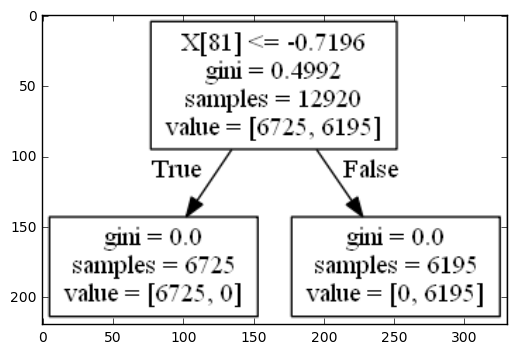

In [7]:
# Use command line to plot tree in image
#dot -Tpng tree.dot -o tree.png

plt.imshow(mpimg.imread('tree.png'))
plt.show()

#### Illutrate the HoG block that matters the most to making decision on a vehicle and a non-vehicle image. 

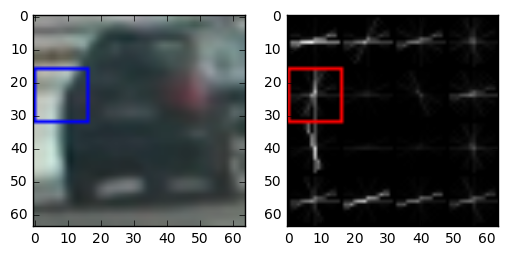

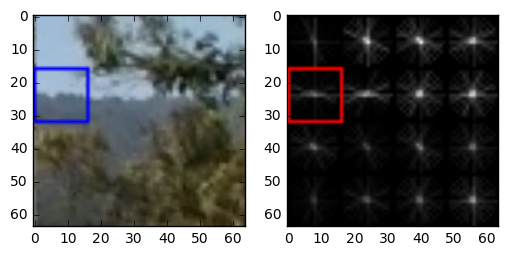

In [83]:
img_path=os.getcwd()+'/datasets/vehicles/GTI_Left/image0019.png'
draw_hog_block(img_path)

img_path=os.getcwd()+'/datasets/non-vehicles/Extras/extra9.png'
draw_hog_block(img_path)

## Decision Tree Pruning
Now try to fit decision tree using only 1 bin of HOG from previous result. The accuracy is the same as previously!

In [96]:
X_train, X_test, y_train, y_test=process_datasets(features='hog_and_color',hog_idx=[81])
clf=tree.DecisionTreeClassifier()
clf.fit(X_train,y_train)

pred=clf.predict(X_test)
accuracy=np.mean(pred==y_test)
print('Test accuracy', accuracy)

KeyboardInterrupt: 

# SVM


In [87]:
X_train, X_test, y_train, y_test=process_datasets(features='hog_and_color', color_space='LUV')

clf=svm.SVC(kernel='linear')
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)
val_acc=accuracy_score(y_test, y_pred)
print('Validation accuray %.4f'%val_acc)

Validation accuray 0.9744


In [61]:
def predict_vehicle(clf, image):
    image=cv2.resize(image,(64,64))
    feat=extract_features(image, feature='hog_and_color', color_space='LUV')

    feat=feat.reshape(1,-1)   
    #scaler=StandardScaler().fit(feat.astype(np.float64))    
    #feat=scaler.transform(feat)

    return(clf.predict(feat))
    

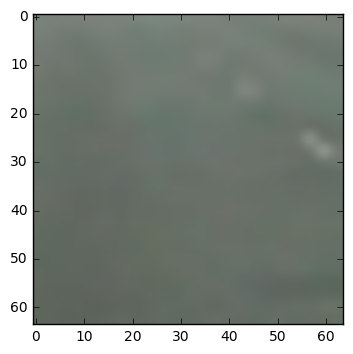

[0]


In [62]:
img_path='./datasets/non-vehicles/GTI/image1.png'
#img_path='./datasets/vehicles/KITTI_extracted/1.png'

img=read_image(img_path)

plt.imshow(img)
plt.show()

print(predict_vehicle(clf, img))


## Sliding Windows

<IPython.core.display.Javascript object>


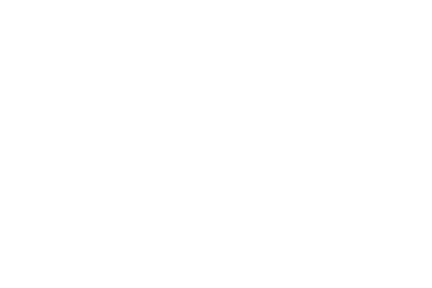

<IPython.core.display.Javascript object>


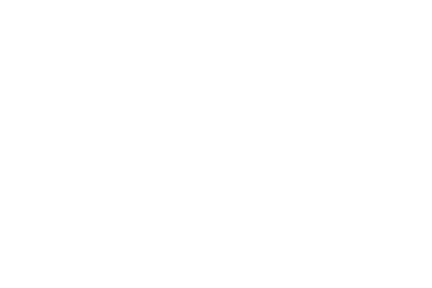

In [63]:
# Load test image
%matplotlib notebook
img=read_image('test750.jpg')
y_search_min=400
y_search_max=660
img2=draw_boxes(img, [((0,y_search_min), (1279,y_search_max))],thick=6)
plt.imshow(img2)
plt.show()

In [64]:
def sliding_window_row(img, window_size, step_size, y_loc, dbg=False):
    
    for y_top in range(y_loc[0], y_loc[1],step_size[1]):
        y_bottom=y_top+window_size[1]
        if y_bottom>y_loc[1]:
            break
        for x_left in range(0, img.shape[1],step_size[0]):            
            x_right=x_left+window_size[0]
            if x_right>img.shape[1]:
                break
            window=img[y_top:y_bottom,x_left:x_right,:]
            detected=predict_vehicle(clf, window)
            if dbg==True or detected:
                yield(((x_left,y_top),(x_right,y_bottom)))
            else:
                yield None
            
    

In [78]:
# window size, steps, and y positions (start,end) to search
multiscale_windows=[[(80,80),(20,20),(400,500)],
                    [(100,100),(20,20),(400,660)],
                    [(150,150),(50,50),(400,660)]
                   ]

def detect_car(img, multiscale_windows):
    boxes=[]
    for window_step in multiscale_windows:
        for box in sliding_window_row(img, window_step[0] ,window_step[1], window_step[2], dbg=False):
            if box is not None:
                #img3=draw_boxes(img3, [box],thick=6)
                boxes.append(box)
    return np.array(boxes)


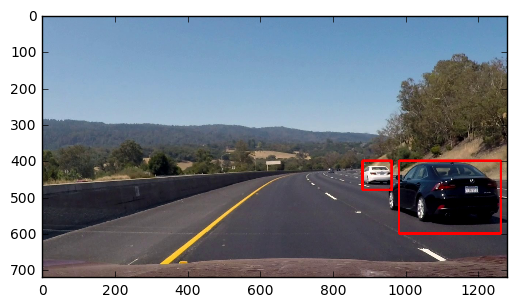

In [100]:
%matplotlib inline
boxes=detect_car(img, multiscale_windows)

# part of code taken from http://www.pyimagesearch.com/2014/11/17/non-maximum-suppression-object-detection-python/
# to find overlapping rectangles

def clean_up_boxes(boxes, overlapThresh):
    if len(boxes)==0:
        return []
    
    # initialise clean boxes
    cleaned_boxes=[]

    # grab coordinates of the bounding boxes

    x1 = boxes[:,0,0]
    y1 = boxes[:,0,1]
    x2 = boxes[:,1,0]
    y2 = boxes[:,1,1]
    
    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)    
    count=len(idxs)
    while len(idxs) > 0 and count>0:
        count=count-1
        last = len(idxs)-1        
        i=idxs[last]
        suppress=[]
        overlap_flag=False
        for pos in range(0, last):

            # grab the current index
            j = idxs[pos]

            # find the largest (x, y) coordinates for the start of
            # the bounding box and the smallest (x, y) coordinates
            # for the end of the bounding box
            xx1 = max(x1[i], x1[j])
            yy1 = max(y1[i], y1[j])
            xx2 = min(x2[i], x2[j])
            yy2 = min(y2[i], y2[j])

            # compute the width and height of the bounding box
            w = max(0, xx2 - xx1 + 1)
            h = max(0, yy2 - yy1 + 1)

            # compute the ratio of overlap between the computed
            # bounding box and the bounding box in the area list
            overlap = float(w * h) / area[j]

            # if there is sufficient overlap, merge them
            # and mark the current box to be deleted
            if overlap > overlapThresh:
                x1[i]=min(x1[i],x1[j])
                y1[i]=min(y1[i],y1[j])
                x2[i]=max(x2[i],x2[j])
                y2[i]=max(y2[i],y2[j])
                suppress.append(pos)
                overlap_flag=True
            else:
                overlap_flag=False

        if overlap_flag==False:
            cleaned_boxes.append(((x1[i],y1[i]),(x2[i],y2[i])))
            suppress.append(last)
        
        idxs = np.delete(idxs, suppress)
        #print('last',last, 'i', i)
        #print('suppress',suppress,'idxs', idxs)
        # delete all indexes from the index list that are in the
        # suppression list
    

    #for i in idxs:
    #    cleaned_boxes.append(((x1[i],y1[i]),(x2[i],y2[i])))

    return cleaned_boxes


boxes=clean_up_boxes(boxes, 0.4)
img3=draw_boxes(img, boxes,thick=6)

plt.imshow(img3)
plt.show()    

# Debugging

In [101]:
cap = cv2.VideoCapture("project_video.mp4") #video_name is the video being called
for fn in range(753,800): # enter the range of frames to view
    cap.set(1,fn); # Where frame_no is the frame you want
    ret, frame = cap.read() # Read the frame
    cv2.imwrite('test753.jpg',frame)
    frame=cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    boxes=detect_car(frame, multiscale_windows)
    boxes=clean_up_boxes(boxes, 0.1)
    aug_frame=draw_boxes(frame, boxes,thick=6)
    
    aug_frame=cv2.cvtColor(aug_frame,cv2.COLOR_RGB2BGR)
    cv2.putText(aug_frame, "Frame "+str(fn), (400, 450),
           cv2.FONT_HERSHEY_SIMPLEX, 2, (0,0,255), 2)    
    
    cv2.imshow('window_name', aug_frame) # show frame on window
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    


In [102]:
cv2.destroyAllWindows()  